[View in Colaboratory](https://colab.research.google.com/github/JacksonIsaac/kadenze-deeplearning-creative-applications/blob/master/Kadenze_session_5.ipynb)

# Kadenze Session 5 - Generative Models

In [0]:
#!rm -rf ./*
!git clone -q https://github.com/JacksonIsaac/CADL.git
!mv CADL/session-5/* .

In [3]:
!pip uninstall -q -y matplotlib && pip install -q matplotlib==2.0.2
!apt-get -qq install -y axel imagemagick

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fontconfig.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package fonts-droid-fallback.
Preparing to unpack .../01-fonts-droid-fallback_1%3a6.0.1r16-1.1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1) ...
Selecting previously unselected package liblqr-1-0:amd64.
Preparing to unpack .../02-liblqr-1-0_0.4.2-2_amd64.deb ...
Unpacking liblqr-1-0:amd64 (0.4.2-2) ...
Selecting previously unselected package libfftw3-double3:amd64.
Preparing to unpack .../03-libfftw3-double3_3.3.6p2-1_amd64.deb ...
Unpacking libfftw3-double3:amd64 (3.3.6p2-1) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../04-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting 

In [3]:
!ls

alice.txt.gz	 parag.png		 trump.ckpt.data-00000-of-00001
arles.png	 README.md		 trump.ckpt.index
CADL		 sample_data		 trump.ckpt.meta
clinton.png	 session-5-part-1.ipynb  trump.txt
lecture-5.ipynb  session-5-part-2.ipynb
libs		 tests


# Import packages

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from libs.datasets import CELEB

# Prepare dataset and set up data pipeline

In [5]:
#files = CELEB()

Could not find celeb dataset under ./img_align_celeba/.
Try downloading the dataset from the "Aligned and Cropped" link located here (imgs/img_align_celeba.zip [1.34 GB]): http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html


In [0]:
!pip install -q kaggle

In [6]:
## Load Kaggle config JSON
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

Download 100%.


In [7]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.20G/1.21G [00:18<00:00, 65.2MB/s]
100% 1.21G/1.21G [00:18<00:00, 69.4MB/s]


In [0]:
!unzip -q celeba-dataset img_align_celeba.zip

In [0]:
!unzip -q img_align_celeba

In [0]:
files = CELEB()

In [0]:
from libs.dataset_utils import create_input_pipeline

In [0]:
batch_size = 100
n_epochs = 10

input_shape = [218, 178, 3]
crop_shape = [64, 64, 3]

crop_factor = 0.8

batch = create_input_pipeline(
    files = files,
    batch_size = batch_size,
    n_epochs = n_epochs,
    crop_shape = crop_shape,
    crop_factor = crop_factor,
    shape = input_shape)

# Tensorflow session setup

In [0]:
sess = tf.Session()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

In [16]:
batch_xs = sess.run(batch)
print(batch_xs.shape)
print(batch_xs.dtype, np.max(batch_xs))

(100, 64, 64, 3)
float32 255.0


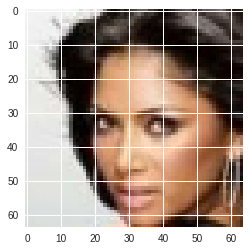

In [17]:
plt.imshow(batch_xs[0] / 255.0)

# Recurrent Neural Networks (RNN)

## Import text file data for LSTM

In [0]:
from six.moves import urllib

In [0]:
f, _ = urllib.request.urlretrieve('https://www.gutenberg.org/cache/epub/11/pg11.txt', 'alice.txt')

In [5]:
!curl https://www.gutenberg.org/cache/epub/11/pg11.txt | gunzip > alice.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60422  100 60422    0     0  60422      0  0:00:01  0:00:01 --:--:-- 36575


In [0]:
with open('alice.txt', 'r', encoding="utf8") as fp:
    txt = fp.read()

In [15]:
txt[:100]

"\ufeffProject Gutenberg's Alice's Adventures in Wonderland, by Lewis Carroll\n\nThis eBook is for the use o"

## Let's create a set of all characters in the text file

In [0]:
vocab = list(set(txt))

In [8]:
len(txt), len(vocab)

(163781, 85)

## Next, we will create a lookup table to map char to int, and vice versa

In [0]:
encoder = dict(zip(vocab, range(len(vocab))))
decoder = dict(zip(range(len(vocab)), vocab))

## Create model parameters

In [0]:
batch_size = 100
seq_length = 100 # No of characters within a sequence
n_cells = 256 # No of cells in RNN layer

n_layers = 2

n_chars = len(vocab)

## Create tf placeholders

In [0]:
X = tf.placeholder(tf.int32, [None, seq_length], name='X')
Y = tf.placeholder(tf.int32, [None, seq_length], name='Y')

### For MNIST, we used one hot encoded vector.
### Here, we will use tf.nn.embedding_lookup

In [12]:
embedding = tf.get_variable("embedding", [n_chars, n_cells])
Xs = tf.nn.embedding_lookup(embedding, X)

print(Xs.get_shape().as_list())

[None, 100, 256]


## Now, we will slice our input sequence

In [0]:
with tf.name_scope('reslice'):
    Xs = [tf.squeeze(seq, [1])
         for seq in tf.split(Xs, seq_length, axis=1)]    

## Create recurrent layer composed of LSTM cell

In [0]:
cells = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_cells, state_is_tuple=True)

In [0]:
initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)

if n_layers > 1:
    cells = tf.nn.rnn_cell.MultiRNNCell(
        [cells] * n_layers, state_is_tuple=True)
    initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)

In [0]:
outputs, state = tf.contrib.rnn.static_rnn(cells, Xs, initial_state=initial_state)

## The above statement would return a list of outputs. 
## We will now stack all the output for each cell.

In [0]:
outputs_flat = tf.reshape(tf.concat(outputs, axis=1), [-1, n_cells])

# Prediction using RNN

In [0]:
with tf.variable_scope('prediction'):
    W = tf.get_variable(
        "W",
        shape=[n_cells, n_chars],
        initializer=tf.random_normal_initializer(stddev=0.1))
    b = tf.get_variable(
        "b",
        shape=[n_chars],
        initializer=tf.random_normal_initializer(stddev=0.1))

    # Find the output prediction of every single character in our minibatch
    # we denote the pre-activation prediction, logits.
    logits = tf.matmul(outputs_flat, W) + b

    # We get the probabilistic version by calculating the softmax of this
    probs = tf.nn.softmax(logits)

    # And then we can find the index of maximum probability
    Y_pred = tf.argmax(probs, axis=1)

## Calculating the loss

In [0]:
with tf.variable_scope('loss'):
    Y_true_flat = tf.reshape(tf.concat(Y, axis=1), [-1])
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y_true_flat)
    mean_loss = tf.reduce_mean(loss)

## Gradient clipping

In [0]:
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    gradients = []
    clip = tf.constant(5.0, name='clip')
    for grad, var in optimizer.compute_gradients(mean_loss):
        gradients.append((tf.clip_by_value(grad, -clip, clip), var))
    updates = optimizer.apply_gradients(gradients)

## Setup session and train

In [0]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [26]:
cursor = 0
it_i = 0

while True:
    Xs, Ys = [], []
    for batch_i in range(batch_size):
        if(cursor + seq_length) >= len(txt) - seq_length - 1:
            cursor = 0
        Xs.append([encoder[ch]
                  for ch in txt[cursor:cursor+seq_length]])
        Ys.append([encoder[ch]
                  for ch in txt[cursor+1:cursor+seq_length+1]])
        cursor = cursor + seq_length
    Xs = np.array(Xs).astype(np.int32)
    Ys = np.array(Ys).astype(np.int32)
    
    loss_val, _ = sess.run([mean_loss, updates],
                          feed_dict={X: Xs, Y: Ys})
    print(it_i, loss_val)
    
    if it_i%500 == 0:
        p = sess.run([Y_pred], feed_dict={X: Xs})[0]
        preds = [decoder[p_i] for p_i in p]
        print("".join(preds).split('\n'))
        
    it_i += 1

0 4.4079924
['??:::????                                                                                           ?????rrr                                                                                            :::::?                                                                                              ??:::rrrrrrrr                                                                                       :?:::rrr                                                                                            ::::rrrrrrrr                                                 :::::::::::          ::                ::::::::::::::::::::         ::::::                        ::::::::::::::::::::::::                 :?:rrr                                                                                              ??????rr                                                                                            :?????                                                                                

KeyboardInterrupt: ignored